Let's work in a binary classification problem, using the imdb dataset

In [75]:
# this first two lines are for deactivating the GPU usage
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#----------------------------------------
import numpy as np
import time

In [76]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Had to downgrade numpy to `1.16.1`, to get rid of the error:  
`Object arrays cannot be loaded when allow_pickle=False`

In [77]:
train_data.shape

(25000,)

In [78]:
train_labels.shape

(25000,)

The data is a list of reviews, converted to indices encoded from a dictionary. We can select the most frequently used words with the `num_words` parameter. The variable `test_labels` is binary, a value of `1` corresponds to a positive review, and `0` for a negative one. 

For example, to get a review back to english we can do: 

In [79]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '!') for i in train_data[0]])

In [80]:
decoded_review

"! this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ! is an amazing actor and now the same being director ! father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ! and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ! to the two little boy's that played the ! of norman and paul they were just brilliant children are often left out of the ! list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

The shift in the `.get` method is due to the way the data in built. The first 3 positions are  the indices for 'padding', 'start of sequence' and 'unknown' 

### Preparing the data

As we can't pass list of integer to a NN, we have to transform them into tensors. Let's one-hot encode them, this converts them to vectors of 1s and 0s.  

In [81]:
start = time.perf_counter()
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 8.139 seconds.


In [82]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [83]:
x_train.shape

(25000, 10000)

In [84]:
# Now we do the same for the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building the network

In [85]:
from keras import models
from keras import layers

In [86]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

The `relu` activation function is defined as `x = max(x, 0)`. It is like a `simplifed` sigmoid centered at 0. 
And the `sigmoid` activation maps the output to a probability value.

Now we compile the model, and give the 3 important parameters: optimizer method, loss function and metrics used. 

In [87]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

We have to monitor the model by using a validation set, let's create it:

In [88]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Now we train the model for 20 epochs, in mini-batches of 512 samples. During the training we monitor the loss and accuracy on the validation data. 

In [89]:
start = time.perf_counter()

history = model.fit(partial_x_train, 
                    partial_y_train, 
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 10s 694us/step - loss: 0.4975 - acc: 0.7956 - val_loss: 0.3716 - val_acc: 0.8718
Epoch 2/20
15000/15000 [==============================] - 3s 225us/step - loss: 0.2958 - acc: 0.9048 - val_loss: 0.2991 - val_acc: 0.8907
Epoch 3/20
15000/15000 [==============================] - 3s 195us/step - loss: 0.2160 - acc: 0.9286 - val_loss: 0.3082 - val_acc: 0.8719
Epoch 4/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.1742 - acc: 0.9431 - val_loss: 0.2832 - val_acc: 0.8840
Epoch 5/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.1415 - acc: 0.9541 - val_loss: 0.2862 - val_acc: 0.8852
Epoch 6/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.1143 - acc: 0.9653 - val_loss: 0.3091 - val_acc: 0.8808
Epoch 7/20
15000/15000 [==============================] - 3s 179us/step - loss: 0.0970 - acc: 0.9710 - val_loss: 0.3147 -

GPU: 58.579 seconds.  
CPU: 56.818 seconds.  
Not much difference

As we saved the output of `model.fit()` in the variable `history`, we can plot the metrics for the training and validation set. 

In [90]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

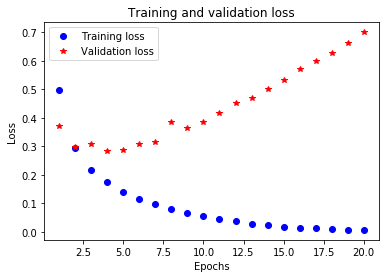

In [91]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now for the accuracy:

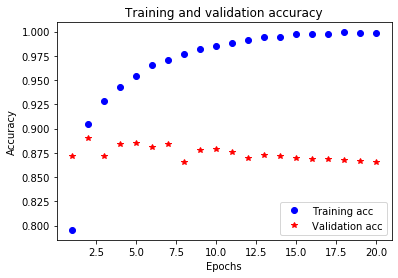

In [92]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that our model is overfitting the data. Its metrics are good for the training data, but are poor for the validation data. We can see that after the third epoch, the model decreases the accuracy and increases the losses for the validation data. We could stop the training at that point to get better results.  

Let's see that, and evaluate the model with the test data.

In [93]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 4s 156us/step - loss: 0.4750 - acc: 0.8218
Epoch 2/4
25000/25000 [==============================] - 3s 136us/step - loss: 0.2655 - acc: 0.9098
Epoch 3/4
25000/25000 [==============================] - 3s 131us/step - loss: 0.1984 - acc: 0.9298
Epoch 4/4
25000/25000 [==============================] - 7s 262us/step


In [94]:
# now we see the loss function and the accuracy
results

[0.3221880063533783, 0.87336]

We have an accuracy of about 87%.

In [95]:
model.predict(x_test)

array([[0.1380194 ],
       [0.99969363],
       [0.30750525],
       ...,
       [0.07190071],
       [0.04400926],
       [0.47793925]], dtype=float32)

Let's try different variations to the same classification problem.

First, let's change the number of hidden layers,  
**3 layers:**

In [96]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 5s 306us/step - loss: 0.5262 - acc: 0.7700 - val_loss: 0.3951 - val_acc: 0.8583
Epoch 2/20
15000/15000 [==============================] - 3s 188us/step - loss: 0.3033 - acc: 0.9028 - val_loss: 0.3373 - val_acc: 0.8630
Epoch 3/20
15000/15000 [==============================] - 3s 181us/step - loss: 0.2191 - acc: 0.9271 - val_loss: 0.3223 - val_acc: 0.8688
Epoch 4/20
15000/15000 [==============================] - 3s 207us/step - loss: 0.1719 - acc: 0.9433 - val_loss: 0.2767 - val_acc: 0.8885
Epoch 5/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.1369 - acc: 0.9560 - val_loss: 0.2973 - val_acc: 0.8842
Epoch 6/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.1113 - acc: 0.9643 - val_loss: 0.3079 - val_acc: 0.8842
Epoch 7/20
15000/15000 [==============================] - 3s 203us/step - loss: 0.0911 - acc: 0.9729 - val_loss: 0.3770 - 

Let's plot the loss and accuracy over training and validation data

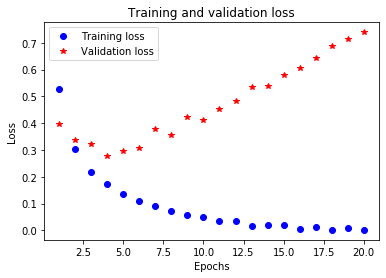

In [97]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

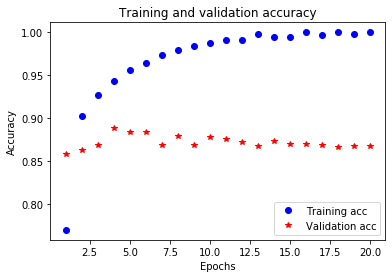

In [98]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This looks much better than the previous model with 2 hidden layers. There is no clear overfitting when evaluating the model on the validation data set.

In [99]:
results

[0.8232948909592629, 0.85072]

However, the accuracy over the test data is much lower, we have of about 84%. This might be overfitting again. 

Let's try with **1 hidden layer**:

In [100]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 243us/step - loss: 0.5076 - acc: 0.8041 - val_loss: 0.4061 - val_acc: 0.8553
Epoch 2/20
15000/15000 [==============================] - 3s 185us/step - loss: 0.3288 - acc: 0.8993 - val_loss: 0.3270 - val_acc: 0.8849
Epoch 3/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.2537 - acc: 0.9243 - val_loss: 0.2928 - val_acc: 0.8894
Epoch 4/20
15000/15000 [==============================] - 3s 183us/step - loss: 0.2096 - acc: 0.9357 - val_loss: 0.2796 - val_acc: 0.8912
Epoch 5/20
15000/15000 [==============================] - 3s 181us/step - loss: 0.1764 - acc: 0.9475 - val_loss: 0.2793 - val_acc: 0.8895
Epoch 6/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.1529 - acc: 0.9549 - val_loss: 0.2742 - val_acc: 0.8899
Epoch 7/20
15000/15000 [==============================] - 3s 189us/step - loss: 0.1338 - acc: 0.9604 - val_loss: 0.2875 - 

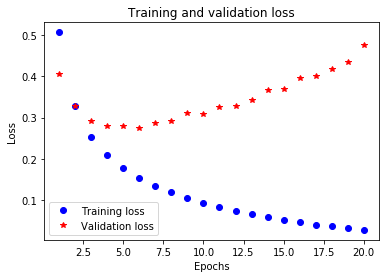

In [101]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

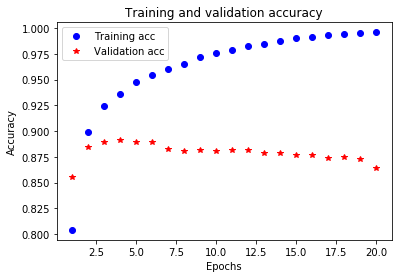

In [102]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [103]:
results

[0.5308870345258713, 0.84964]

We obtained a similar result compared to the model with 3 hidden layers. 

Now, let's repeat the model with 2 hidden layers, but lets change the number of hidden unit:

In [104]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 265us/step - loss: 0.4826 - acc: 0.7744 - val_loss: 0.3378 - val_acc: 0.8758
Epoch 2/20
15000/15000 [==============================] - 3s 206us/step - loss: 0.2620 - acc: 0.9111 - val_loss: 0.3008 - val_acc: 0.8794
Epoch 3/20
15000/15000 [==============================] - 3s 206us/step - loss: 0.1953 - acc: 0.9297 - val_loss: 0.2738 - val_acc: 0.8909
Epoch 4/20
15000/15000 [==============================] - 3s 205us/step - loss: 0.1536 - acc: 0.9453 - val_loss: 0.2957 - val_acc: 0.8857
Epoch 5/20
15000/15000 [==============================] - 3s 205us/step - loss: 0.1195 - acc: 0.9592 - val_loss: 0.3026 - val_acc: 0.8841
Epoch 6/20
15000/15000 [==============================] - 3s 205us/step - loss: 0.0988 - acc: 0.9670 - val_loss: 0.3279 - val_acc: 0.8811
Epoch 7/20
15000/15000 [==============================] - 3s 207us/step - loss: 0.0769 - acc: 0.9758 - val_loss: 0.3499 - 

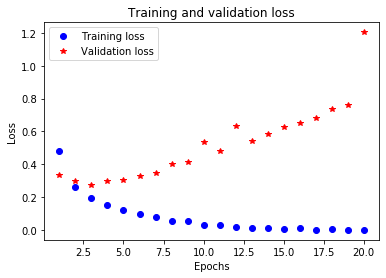

In [105]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

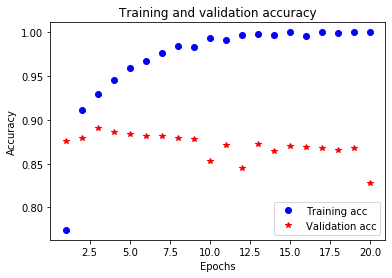

In [106]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [107]:
results

[1.2456739521598816, 0.81696]

Similar accuracy on the test data.

Lets change the model to **64 units** per hidden layer

In [108]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 6s 414us/step - loss: 0.4850 - acc: 0.7781 - val_loss: 0.3857 - val_acc: 0.8387
Epoch 2/20
15000/15000 [==============================] - 4s 271us/step - loss: 0.2650 - acc: 0.8986 - val_loss: 0.3479 - val_acc: 0.8595
Epoch 3/20
15000/15000 [==============================] - 4s 260us/step - loss: 0.1889 - acc: 0.9311 - val_loss: 0.2882 - val_acc: 0.8863
Epoch 4/20
15000/15000 [==============================] - 4s 266us/step - loss: 0.1324 - acc: 0.9533 - val_loss: 0.3407 - val_acc: 0.8740
Epoch 5/20
15000/15000 [==============================] - 4s 259us/step - loss: 0.1116 - acc: 0.9587 - val_loss: 0.3382 - val_acc: 0.8785
Epoch 6/20
15000/15000 [==============================] - 4s 261us/step - loss: 0.0784 - acc: 0.9749 - val_loss: 0.3426 - val_acc: 0.8851
Epoch 7/20
15000/15000 [==============================] - 4s 261us/step - loss: 0.0569 - acc: 0.9819 - val_loss: 0.3771 - 

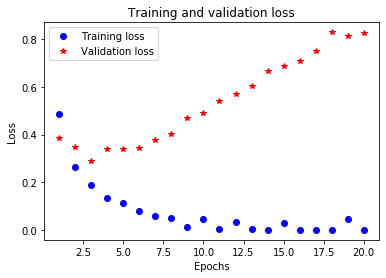

In [109]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

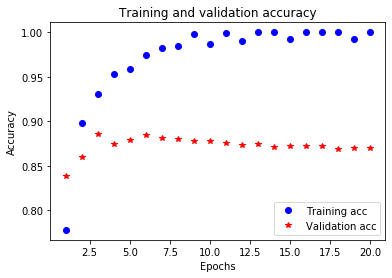

In [110]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [111]:
results

[0.9204900858849288, 0.85608]

85% accuracy on the test data.

Now the model will have a different loss function (**mse**), but with the original **16 units** per hidden layer 

In [112]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='mse',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 257us/step - loss: 0.1741 - acc: 0.7902 - val_loss: 0.1239 - val_acc: 0.8683
Epoch 2/20
15000/15000 [==============================] - 3s 188us/step - loss: 0.0950 - acc: 0.9029 - val_loss: 0.0947 - val_acc: 0.8890
Epoch 3/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.0669 - acc: 0.9292 - val_loss: 0.0857 - val_acc: 0.8915
Epoch 4/20
15000/15000 [==============================] - 3s 183us/step - loss: 0.0526 - acc: 0.9433 - val_loss: 0.0861 - val_acc: 0.8849
Epoch 5/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.0424 - acc: 0.9574 - val_loss: 0.0827 - val_acc: 0.8894
Epoch 6/20
15000/15000 [==============================] - 3s 185us/step - loss: 0.0348 - acc: 0.9644 - val_loss: 0.0863 - val_acc: 0.8827
Epoch 7/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.0289 - acc: 0.9714 - val_loss: 0.0871 - 

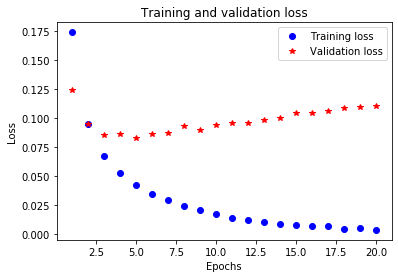

In [113]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

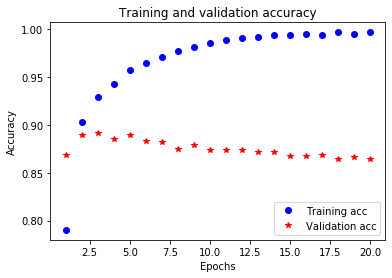

In [114]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [115]:
results

[0.121407424710989, 0.85132]

### Regularization methods

Lets compare what happens when changing the models capacity to extreme values, to get a clear under and overfitting.

In [117]:
# Original model
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 4s 260us/step - loss: 0.5179 - acc: 0.7929 - val_loss: 0.3935 - val_acc: 0.8678
Epoch 2/15
15000/15000 [==============================] - 3s 189us/step - loss: 0.3128 - acc: 0.9025 - val_loss: 0.3173 - val_acc: 0.8821
Epoch 3/15
15000/15000 [==============================] - 3s 179us/step - loss: 0.2281 - acc: 0.9275 - val_loss: 0.2864 - val_acc: 0.8865
Epoch 4/15
15000/15000 [==============================] - 3s 180us/step - loss: 0.1827 - acc: 0.9409 - val_loss: 0.2763 - val_acc: 0.8905
Epoch 5/15
15000/15000 [==============================] - 3s 190us/step - loss: 0.1450 - acc: 0.9549 - val_loss: 0.2971 - val_acc: 0.8829
Epoch 6/15
15000/15000 [==============================] - 3s 186us/step - loss: 0.1221 - acc: 0.9631 - val_loss: 0.2912 - val_acc: 0.8863
Epoch 7/15
15000/15000 [==============================] - 3s 185us/step - loss: 0.1024 - acc: 0.9694 - val_loss: 0.3153 - 

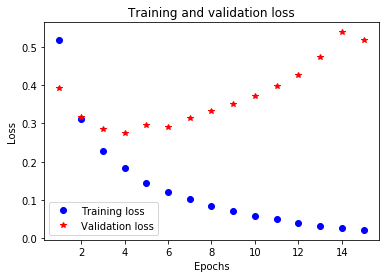

In [119]:
history_dict_original = history.history
loss_values_original = history_dict_original['loss']
val_loss_values_original = history_dict_original['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values_original, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values_original, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [120]:
# A model with fewer parameters
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 4s 252us/step - loss: 0.5886 - acc: 0.7573 - val_loss: 0.5023 - val_acc: 0.8434
Epoch 2/15
15000/15000 [==============================] - 3s 178us/step - loss: 0.4307 - acc: 0.8867 - val_loss: 0.4057 - val_acc: 0.8699
Epoch 3/15
15000/15000 [==============================] - 3s 178us/step - loss: 0.3348 - acc: 0.9117 - val_loss: 0.3427 - val_acc: 0.8852
Epoch 4/15
15000/15000 [==============================] - 3s 174us/step - loss: 0.2714 - acc: 0.9264 - val_loss: 0.3076 - val_acc: 0.8874
Epoch 5/15
15000/15000 [==============================] - 3s 171us/step - loss: 0.2276 - acc: 0.9367 - val_loss: 0.2880 - val_acc: 0.8884
Epoch 6/15
15000/15000 [==============================] - 3s 171us/step - loss: 0.1948 - acc: 0.9428 - val_loss: 0.2766 - val_acc: 0.8897loss: 0.1928 - acc
Epoch 7/15
15000/15000 [==============================] - 3s 171us/step - loss: 0.1699 - acc: 0.9511 - v

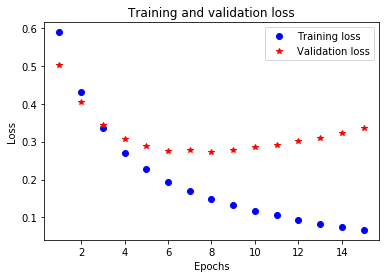

In [121]:
history_dict_under = history.history
loss_values_under = history_dict_under['loss']
val_loss_values_under = history_dict_under['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values_under, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values_under, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [122]:
# A model with much more parameters
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 16s 1ms/step - loss: 0.5492 - acc: 0.7512 - val_loss: 0.3030 - val_acc: 0.8810
Epoch 2/15
15000/15000 [==============================] - 15s 987us/step - loss: 0.2592 - acc: 0.8960 - val_loss: 0.2693 - val_acc: 0.8881
Epoch 3/15
15000/15000 [==============================] - 16s 1ms/step - loss: 0.1611 - acc: 0.9375 - val_loss: 0.2705 - val_acc: 0.8899
Epoch 4/15
15000/15000 [==============================] - 18s 1ms/step - loss: 0.0853 - acc: 0.9722 - val_loss: 0.3520 - val_acc: 0.8898
Epoch 5/15
15000/15000 [==============================] - 26s 2ms/step - loss: 0.0519 - acc: 0.9900 - val_loss: 0.6043 - val_acc: 0.8429
Epoch 6/15
15000/15000 [==============================] - 19s 1ms/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.4719 - val_acc: 0.8884
Epoch 7/15
15000/15000 [==============================] - 15s 1ms/step - loss: 5.3138e-04 - acc: 1.0000 - val_loss: 0.5560 - v

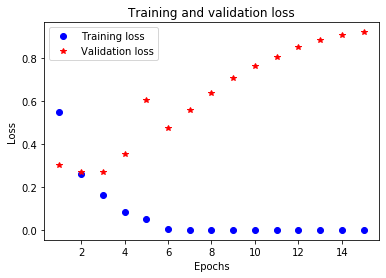

In [123]:
history_dict_over = history.history
loss_values_over = history_dict_over['loss']
val_loss_values_over = history_dict_over['val_loss']
epochs = range(1, len(loss_values_over) + 1)
plt.plot(epochs, loss_values_over, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values_over, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now, let's compare the loss on the validation data for the three cases 

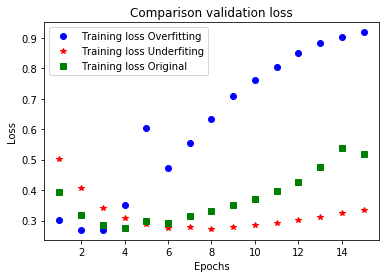

In [125]:
plt.clf()
epochs = range(1, len(loss_values_over) + 1)
plt.plot(epochs, val_loss_values_over, 'bo', label='Training loss Overfitting')
plt.plot(epochs, val_loss_values_under, 'r*', label='Training loss Underfiting')
plt.plot(epochs, val_loss_values_original, 'gs', label='Training loss Original')
plt.title('Comparison validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the more parameters, the faster the overfitting is reached, and the worse it performs after many iterations on the training set. The same comparison can be done on the training loss. 

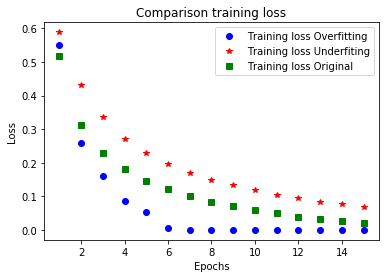

In [126]:
plt.clf()
epochs = range(1, len(loss_values_over) + 1)
plt.plot(epochs, loss_values_over, 'bo', label='Training loss Overfitting')
plt.plot(epochs, loss_values_under, 'r*', label='Training loss Underfiting')
plt.plot(epochs, loss_values_original, 'gs', label='Training loss Original')
plt.title('Comparison training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model with more capacity, that shows more overfitting, reaches faster a low loss value. 

### Adding weight regularization

In [127]:
from keras import regularizers

In [128]:
# A model with L2 regularization (cost is proportional to the square of the value of the NN parameters)
model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 4s 278us/step - loss: 0.6132 - acc: 0.7722 - val_loss: 0.4746 - val_acc: 0.8637
Epoch 2/15
15000/15000 [==============================] - 3s 189us/step - loss: 0.3871 - acc: 0.8918 - val_loss: 0.3932 - val_acc: 0.8626
Epoch 3/15
15000/15000 [==============================] - 3s 195us/step - loss: 0.3047 - acc: 0.9147 - val_loss: 0.3400 - val_acc: 0.8873
Epoch 4/15
15000/15000 [==============================] - 3s 184us/step - loss: 0.2641 - acc: 0.9289 - val_loss: 0.3310 - val_acc: 0.8891
Epoch 5/15
15000/15000 [==============================] - 3s 178us/step - loss: 0.2390 - acc: 0.9401 - val_loss: 0.3481 - val_acc: 0.8822
Epoch 6/15
15000/15000 [==============================] - 3s 181us/step - loss: 0.2243 - acc: 0.9437 - val_loss: 0.3403 - val_acc: 0.8843
Epoch 7/15
15000/15000 [==============================] - 3s 180us/step - loss: 0.2136 - acc: 0.9479 - val_loss: 0.3414 - 

In [129]:
history_dict_l2reg = history.history
loss_values_l2reg = history_dict_l2reg['loss']
val_loss_values_l2reg = history_dict_l2reg['val_loss']

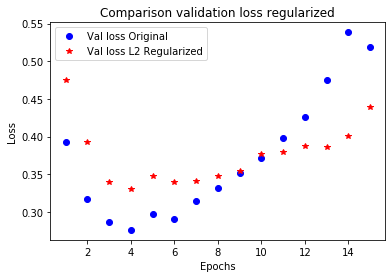

In [130]:
epochs = range(1, len(loss_values_over) + 1)
plt.plot(epochs, val_loss_values_original, 'bo', label='Val loss Original')
plt.plot(epochs, val_loss_values_l2reg, 'r*', label='Val loss L2 Regularized')
plt.title('Comparison validation loss regularized')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see the regularized model overfits less than the original model, even though they have the same number of parameters (capacity).

### Adding dropout

In [131]:
# A model with 0.5 rate dropout
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=15, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 5s 324us/step - loss: 0.6303 - acc: 0.6445 - val_loss: 0.5429 - val_acc: 0.8331
Epoch 2/15
15000/15000 [==============================] - 3s 189us/step - loss: 0.5202 - acc: 0.7713 - val_loss: 0.4456 - val_acc: 0.8572
Epoch 3/15
15000/15000 [==============================] - 3s 184us/step - loss: 0.4429 - acc: 0.8311 - val_loss: 0.3956 - val_acc: 0.8614
Epoch 4/15
15000/15000 [==============================] - 3s 184us/step - loss: 0.3810 - acc: 0.8715 - val_loss: 0.3517 - val_acc: 0.8811
Epoch 5/15
15000/15000 [==============================] - 3s 182us/step - loss: 0.3413 - acc: 0.8889 - val_loss: 0.3253 - val_acc: 0.8824
Epoch 6/15
15000/15000 [==============================] - 3s 183us/step - loss: 0.2964 - acc: 0.9085 - val_loss: 0.3170 - val_acc: 0.8834
Epoch 7/15
15000/15000 [==============================] - 3s 184us/step - loss: 0.2682 - acc: 0.9224 - val_loss: 0.3322 - 

In [132]:
history_dict_drop = history.history
loss_values_drop = history_dict_drop['loss']
val_loss_values_drop = history_dict_drop['val_loss']

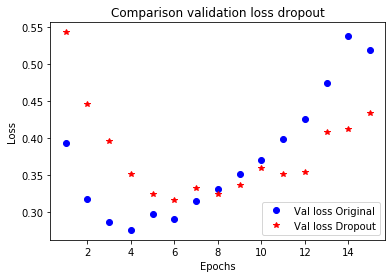

In [133]:
epochs = range(1, len(loss_values_over) + 1)
plt.plot(epochs, val_loss_values_original, 'bo', label='Val loss Original')
plt.plot(epochs, val_loss_values_drop, 'r*', label='Val loss Dropout')
plt.title('Comparison validation loss dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Again, we see the regularized model performs better.